### 1. Import Library Preprocessing

Data yang dipakai adalah `Customer-Churn-Records.csv`.

In [47]:
!pip install xgboost==1.2.0

Defaulting to user installation because normal site-packages is not writeable


In [48]:
# Mengimpor library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, MaxAbsScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

### 2. Data Understanding

In [49]:
# Membaca dataset
df = pd.read_csv('Customer-Churn-Records.csv')

print(df.shape)

df.head()

(10000, 18)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [50]:
df.drop(['RowNumber', 'CustomerId', 'Surname', 'Geography', 'Gender', 'Card Type', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Complain', 'EstimatedSalary', 'Point Earned', 'Satisfaction Score', 'Tenure'], axis=1, inplace=True)
df.head()

,CreditScore,Age,Balance,Exited
0,619,42,0.00,1
1,608,41,83807.86,0
2,502,42,159660.80,1
3,699,39,0.00,0
4,850,43,125510.82,0


In [51]:
#Mengecek data kosong
df.isnull().mean()

CreditScore    0.0
Age            0.0
Balance        0.0
Exited         0.0
dtype: float64

Data ini memiliki 10000 baris dan 14 kolom

In [52]:
df = df.rename(columns={'Satisfaction Score': 'SatisfactionScore'})
print(df)

      CreditScore  Age    Balance  Exited
0             619   42       0.00       1
1             608   41   83807.86       0
2             502   42  159660.80       1
3             699   39       0.00       0
4             850   43  125510.82       0
...           ...  ...        ...     ...
9995          771   39       0.00       0
9996          516   35   57369.61       0
9997          709   36       0.00       1
9998          772   42   75075.31       1
9999          792   28  130142.79       0

[10000 rows x 4 columns]


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CreditScore  10000 non-null  int64  
 1   Age          10000 non-null  int64  
 2   Balance      10000 non-null  float64
 3   Exited       10000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 312.6 KB


<br>

In [54]:
#menentukan variabel X dan Y 
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [55]:
X.head()

,CreditScore,Age,Balance
0,619,42,0.00
1,608,41,83807.86
2,502,42,159660.80
3,699,39,0.00
4,850,43,125510.82


In [56]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [57]:
#Spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#Reset index dengan looping
for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(drop=True, inplace=True)

print(X_train.shape, X_test.shape)

(8000, 3) (2000, 3)


In [58]:
target = 'Exited'

### Menentukan Variabel numerik dan Kategori

In [59]:
var_kategori = [var for var in df.columns if df[var].dtype=='O' and var!=target]
var_numerik = [var for var in df.columns if df[var].dtype!='O' and var!=target]
print(var_numerik)
print(var_kategori)

['CreditScore', 'Age', 'Balance']
[]


### Preprocessing dengan Library Pipeline

In [60]:
# Membuat Pipeline untuk preprocessing
preprocessor_numerik = Pipeline([
    ('imputasi', SimpleImputer(strategy='median')),
    ('scaling', MinMaxScaler())
])

preprocessor_kategori = Pipeline([
    ('imputasi', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoding', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))         
])

# Menggabungkan kedua pipeline di atas
preprocessor = ColumnTransformer([
    ('preprocessing numerik', preprocessor_numerik, var_numerik),
    ('preprocessing kategori', preprocessor_kategori, var_kategori)
])

In [61]:
logreg = LogisticRegression()

# Pipeline model regresi logistik
pipe_logreg = Pipeline([
    ('preprocessing', preprocessor),
    ('logreg', logreg)
])

In [62]:
# Fitting ke training set
pipe_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('preprocessing numerik',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Balance']),
                                                 ('preprocessing kategori',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('logreg', LogisticRegression())])

In [63]:
X_train

,CreditScore,Age,Balance
0,667,34,0.00
1,427,42,75681.52
2,535,29,112367.34
3,654,40,105683.63
4,850,57,126776.30
...,...,...,...
7995,594,32,120074.97
7996,794,22,114440.24
7997,738,35,161274.05
7998,590,38,0.00


In [64]:
# Mencoba memprediksi test set
pred_test = pipe_logreg.predict(X_test)

# Merubahnya ke format Dataframe
pred_test = pd.DataFrame(pred_test, columns=[target])

# Melihat tmapilan y_pred
pred_test.head()

,Exited
0,0
1,0
2,0
3,0
4,0


In [65]:
# Membuat Confusion Matrix
cm_logreg = confusion_matrix(y_test, pred_test)
cm_logreg

array([[1533,   62],
       [ 380,   25]], dtype=int64)

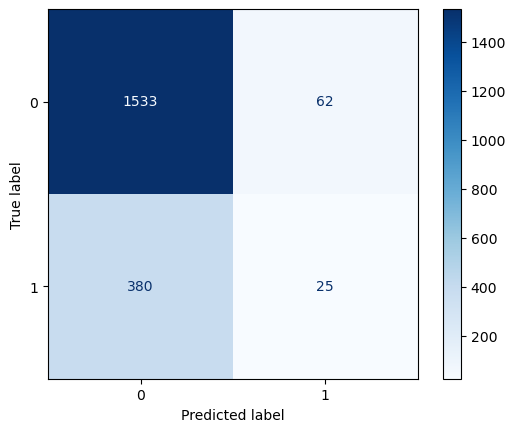

In [66]:
# Melihat confusion matrix dengan ConfusionMatrixDisplay()
vis_cm = ConfusionMatrixDisplay(confusion_matrix = cm_logreg,
                                display_labels = pipe_logreg.classes_)
vis_cm.plot(cmap=plt.cm.Blues); # cm adalah singkatan dari colormap

In [67]:
# Melihat ringkasan evaluasi
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1595
           1       0.29      0.06      0.10       405

    accuracy                           0.78      2000
   macro avg       0.54      0.51      0.49      2000
weighted avg       0.70      0.78      0.72      2000



In [68]:
# Menghitung metrics klasifikasi satu per satu
print('Nilai akurasi: {:.2f}'.format(accuracy_score(y_test, pred_test)))
print('Nilai presisi: {:.2f}'.format(precision_score(y_test, pred_test)))
print('Nilai recall: {:.2f}'.format(recall_score(y_test, pred_test)))
print('Nilai f1: {:.2f}'.format(f1_score(y_test, pred_test)))
print('Nilai AUC: {:.2f}'.format(roc_auc_score(y_test, pipe_logreg.predict_proba(X_test)[:,1])))

Nilai akurasi: 0.78
Nilai presisi: 0.29
Nilai recall: 0.06
Nilai f1: 0.10
Nilai AUC: 0.75


<br>

### Memilih model yang terbaik

### 1. Logistic Regression

In [69]:
#model Logistik regresi
modreg = LogisticRegression()

preproc_modreg = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('modreg', modreg)
])

#hyperparamter Logregresi
param_modreg = {'modreg__penalty': ['l2'],
                'modreg__C': [0.01, 0.09, 0.1, 0.125, 1, 1.5],
                'modreg__solver' : ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']
               }


<br>

### 2. *Decision Tree*

In [70]:
# Model DT
dt = DecisionTreeClassifier(random_state= 0)

# Pipeline model DT
pipe_dt = Pipeline([
    ('preprocessing', preprocessor),
    ('dt', dt)
])

# Hyperparameter tuning DT
param_dt = {'dt__min_samples_split': [2, 3, 4],
            'dt__min_samples_leaf': [1, 2, 3, 4],
            'dt__criterion': ['gini', 'entropy','log_loss'],
            'dt__max_depth':[1,2,3,4]
           }

### 3. SVM

In [71]:
#model SVM
modsvm = SVC(kernel = 'rbf', probability=True, random_state=0)

preproc_modsvm = Pipeline([
    ('preprocessing', preprocessor),
    ('modsvm', modsvm)
])

# Hyperparameter tuning SVM
param_modsvm = {'modsvm__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1],
             'modsvm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'modsvm__degree': [1, 2, 3, 4, 5],
             'modsvm__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
            }
    

<br>

### 4. KNN

In [72]:
#model KNN
modknn = KNeighborsClassifier()

preproc_modknn = Pipeline([
    ('preprocessing', preprocessor),
    ('modknn', modknn)
])

# Hyperparameter tuning KNN
param_modknn = {'modknn__n_neighbors': [1, 2, 3, 4, 5],
             'modknn__weights': ['uniform', 'distance'],
             'modknn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }

<br>

### 5. Random Forest

In [73]:
#model Random Forest
moderf = RandomForestClassifier()

preproc_moderf= Pipeline([
    ('preprocessing', preprocessor),
    ('moderf', moderf)
])

# Hyperparameter tuning RF
param_moderf = {'moderf__n_estimators': [200, 250, 300],
            'moderf__criterion': ['gini', 'entropy', 'log_loss'],
            'moderf__max_depth': [1, 2, 3, 4],
            'moderf__min_samples_split': [2, 3],
            'moderf__min_samples_leaf': [1, 2, 3],
            'moderf__warm_start': [True]
            }

<br>

### 6 AdaBoost

In [74]:
#model Adaboost
modeAbost = AdaBoostClassifier()

preproc_aboost = Pipeline([
    ('preprocessing', preprocessor),
    ('modeAbost', modeAbost)
])

# Hyperparameter tuning AdaBoost
param_modeAbost = {'modeAbost__n_estimators': [10, 20, 30, 50, 70],
             'modeAbost__learning_rate': [0.3, 0.4, 0.5, 1, 1.1],
             'modeAbost__algorithm': ['SAMME', 'SAMME.R'],
             }

<br>

### 7 Gradient Boosting

In [75]:
#model gradient boost
modGboost = GradientBoostingClassifier()

preproc_gb = Pipeline([
    ('preprocessing', preprocessor),
    ('modGboost', modGboost)
])

# Hyperparameter tuning regresi GBoost
param_gb = {'modGboost__loss': ['log_loss', 'exponential'],
            'modGboost__learning_rate': [0.1, 0.3, 0.4, 0.5, 1, 1.1],
            'modGboost__n_estimators': [10, 20, 30, 50, 70]}

<br>

### 8 XGBoost

In [76]:
#model XGBoost
modexgboost = XGBClassifier(eval_metric='logloss', random_state=1)

preproc_modesxgboos = Pipeline([
    ('preprocessing', preprocessor),
    ('modexgboost', modexgboost)
])

# hyperparameter tuning
param_modexgboost = {'modexgboost__learning_rate': [0.05, 0.1, 0.2],
             'modexgboost__max_depth': [5, 7, 9],
             'modexgboost__gamma': [0, 0.1, 0.2]
            }

<br>

melakukan model training dengan cross validation.

Daftar metrik yang bisa dipakai menggunakan perintah cross_val_score():

In [77]:
# Model training dengan cross validation
daftar_model = [preproc_modreg, pipe_dt, preproc_modsvm, preproc_modknn, preproc_moderf, preproc_aboost, preproc_gb, preproc_modesxgboos]
daftar_nama_model = ['modreg', 'dt', 'modsvm', 'modknn', 'moderf', 'modeAbost', 'modGboost', 'modexgboost'] 
mean_akurasi = []
mean_auc = []
std_akurasi = []
std_auc = []
test_score_akurasi = []
test_score_auc = []

# Kita setting agar proses cross validasi dilakukan dengan sama rata (stratified) untuk pembagian kategori labelnya
skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
cv = skf

# Looping untuk setiap model yang sudah disiapkan 
for i in daftar_model:
    
    # Melakukan cross validation dan menggunakan kriteria berdasarkan skor akurasi
    cv_akurasi = cross_val_score(i, X_train, y_train, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)  # kita kalikan dengan -1 karena scoring menggunakan nilai negatif
    cv_auc = cross_val_score(i, X_train, y_train, cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)
    
    # Menghitung nilai rata-rata akurasi dan menambahkannya ke variabel mean_akurasi
    mean_akurasi.append(round(cv_akurasi.mean(),2))   # round(nilai,2) untuk membulatkan nilai 2 angka di belakang koma
    mean_auc.append(round(cv_auc.mean(),2))

    # Menghitung nilai standar deviasi akurasi dan menambahkannya ke variabel std_akurasi
    std_akurasi.append(round(cv_akurasi.std(),2))
    std_auc.append(round(cv_auc.std(),2))
    
    # Melakukan fitting training set kemudian melakukan prediksi  di test set
    i.fit(X_train, y_train)
    i_predict = i.predict(X_test)
    
    # Menghitung nilai rata-rata akurasi di test set dan menambahkannya ke variabel test_score_akurasi
    test_score_akurasi.append(round(accuracy_score(y_test, i_predict),2))
    test_score_auc.append(round(roc_auc_score(y_test, i_predict),2))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3

In [78]:
# Membuat DataFrame
cv_akurasi = pd.DataFrame({'model':daftar_nama_model, 'Train_Mean':mean_akurasi, 'std':std_akurasi, 'Test_Score':test_score_akurasi})
cv_auc = pd.DataFrame({'model':daftar_nama_model, 'Train_Mean':mean_auc, 'std':std_auc, 'Test_Score':test_score_auc})

In [79]:
# Melihat hasil cross validation berdasarkan akurasi
cv_akurasi

,model,Train_Mean,std,Test_Score
0,modreg,0.78,0.00,0.78
1,dt,0.73,0.01,0.73
2,modsvm,0.80,0.00,0.80
3,modknn,0.79,0.00,0.79
4,moderf,0.78,0.00,0.78
5,modeAbost,0.81,0.00,0.81
6,modGboost,0.81,0.00,0.81
7,modexgboost,0.79,0.00,0.80


In [80]:
# Melihat hasil cross validation berdasarkan akurasi
cv_auc

,model,Train_Mean,std,Test_Score
0,modreg,0.73,0.01,0.51
1,dt,0.58,0.01,0.60
2,modsvm,0.69,0.00,0.50
3,modknn,0.69,0.00,0.60
4,moderf,0.71,0.01,0.61
5,modeAbost,0.75,0.01,0.60
6,modGboost,0.76,0.00,0.60
7,modexgboost,0.72,0.00,0.61


In [81]:
# Mengurutkan skor dari kecil ke besar berdasarkan skor akurasi
cv_akurasi_urut = cv_akurasi.sort_values(by=['Train_Mean', 'Test_Score'], ascending=False,  ignore_index=True)
cv_akurasi_urut

,model,Train_Mean,std,Test_Score
0,modeAbost,0.81,0.00,0.81
1,modGboost,0.81,0.00,0.81
2,modsvm,0.80,0.00,0.80
3,modexgboost,0.79,0.00,0.80
4,modknn,0.79,0.00,0.79
5,modreg,0.78,0.00,0.78
6,moderf,0.78,0.00,0.78
7,dt,0.73,0.01,0.73


In [82]:
# Mengurutkan skor dari kecil ke besar berdasarkan skor AUC
cv_auc_urut = cv_auc.sort_values(by=['Train_Mean', 'Test_Score'], ascending=False,  ignore_index=True)
cv_auc_urut

,model,Train_Mean,std,Test_Score
0,modGboost,0.76,0.00,0.60
1,modeAbost,0.75,0.01,0.60
2,modreg,0.73,0.01,0.51
3,modexgboost,0.72,0.00,0.61
4,moderf,0.71,0.01,0.61
5,modknn,0.69,0.00,0.60
6,modsvm,0.69,0.00,0.50
7,dt,0.58,0.01,0.60


Berdasarkan pemilihan model dengan skor akurasi tertinggi adalah adaboost yang menempati urutan 1 .
dan skor AUC skor tertinggi adalah juga gradientboost.
ada dua pilihan terbaik, gradientboost berdasarkan auc yang dipakai

<br>

### Menerapkan Hyperparameter Tuning

kali mencoba lagi membandingkan semua model diatas tadi dengan tambahan hy[erparameter tuning dengan GridSearchCV() 

In [83]:
# Model training dengan GridSearchCV
daftar_model = [preproc_modreg, pipe_dt, preproc_modsvm, preproc_modknn,
                preproc_moderf, preproc_aboost, preproc_gb, preproc_modesxgboos]
daftar_nama_model = ['modreg', 'dt', 'modsvm', 'modknn', 'moderf', 'modeAbost', 'modGboost', 'modexgboost']
daftar_param_model = [param_modreg, param_dt, param_modsvm, param_modknn, param_moderf,
                      param_modeAbost, param_gb, param_modexgboost]

# Nilai yang akan diisikan
akurasi_tuning = []
akurasi_tuning_test = []
auc_tuning = []
auc_tuning_test = []
best_param = []
best_estimator = []

for i in range(len(daftar_model)):
    
    # Menjalankan GridSearchCV
    model_grid_cv = GridSearchCV(
        daftar_model[i],
        daftar_param_model[i],
        cv=3,
        scoring='accuracy',  # nilai akurasi digunakan sebagai dasar penentuan peringkat parameter terbaik dan parameter scoring ini bisa diganti yang lain
        verbose=1,
        n_jobs=-1
        )
    
    # Fitting ke training set
    model_grid_cv.fit(X_train,y_train)
    
    # Mencoba memprediksi training dan test set setelah fitting di training set, kemudian dikemas dalam format DataFrame
    pred_train = pd.DataFrame(model_grid_cv.predict(X_train), columns=['Beli'])
    pred_test = pd.DataFrame(model_grid_cv.predict(X_test), columns=['Beli'])

    # Mencatat skor akurasi training dan test set
    akurasi_tuning.append(accuracy_score(y_train, pred_train))
    akurasi_tuning_test.append(accuracy_score(y_test, pred_test))

    # Mencatat skor AUC training dan test set
    auc_tuning.append(roc_auc_score(y_train, model_grid_cv.predict_proba(X_train)[:,1]))
    auc_tuning_test.append(roc_auc_score(y_test, model_grid_cv.predict_proba(X_test)[:,1])) 
    
    # Mencatat parameter terbaik di setiap model
    best_param.append(model_grid_cv.best_params_)
    
    # Merekam settingan modelnya
    best_estimator.append(model_grid_cv.best_estimator_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 144 candidates, totalling 432 fits
Fitting 3 folds for each of 700 candidates, totalling 2100 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [84]:
# Membuat DataFrame sekaligus kita urutkan
grid_akurasi = pd.DataFrame({'model':daftar_nama_model, 'Training':akurasi_tuning, 'Testing':akurasi_tuning_test})
grid_akurasi_urut = grid_akurasi.sort_values(by='Testing', ascending=False,  ignore_index=True)

grid_auc = pd.DataFrame({'model':daftar_nama_model, 'Training':auc_tuning, 'Testing':auc_tuning_test})
grid_auc_urut = grid_auc.sort_values(by='Testing', ascending=False, ignore_index=True)

In [85]:
grid_akurasi_urut

,model,Training,Testing
0,modexgboost,0.826125,0.8160
1,modGboost,0.819375,0.8155
2,dt,0.809375,0.8140
3,modeAbost,0.813375,0.8120
4,moderf,0.798875,0.7985
5,modreg,0.795875,0.7975
6,modsvm,0.795875,0.7975
7,modknn,0.840875,0.7950


In [86]:
grid_auc_urut

,model,Training,Testing
0,modexgboost,0.809740,0.770234
1,modeAbost,0.774432,0.769736
2,modGboost,0.789241,0.769211
3,dt,0.764898,0.767021
4,moderf,0.769738,0.765958
5,modsvm,0.730265,0.740078
6,modreg,0.674669,0.681559
7,modknn,0.887223,0.677453


dari perbandingan model diatas setelah dilakukan cross validation set ternyata Adaboost yang terbaik

In [87]:
level_param = pd.DataFrame({'model':daftar_nama_model, 'Param':best_param})
level_param

,model,Param
0,modreg,"{'modreg__C': 0.01, 'modreg__penalty': 'l2', '..."
1,dt,"{'dt__criterion': 'entropy', 'dt__max_depth': ..."
2,modsvm,"{'modsvm__C': 0.1, 'modsvm__degree': 1, 'modsv..."
3,modknn,"{'modknn__algorithm': 'brute', 'modknn__n_neig..."
4,moderf,"{'moderf__criterion': 'gini', 'moderf__max_dep..."
5,modeAbost,"{'modeAbost__algorithm': 'SAMME.R', 'modeAbost..."
6,modGboost,"{'modGboost__learning_rate': 0.4, 'modGboost__..."
7,modexgboost,"{'modexgboost__gamma': 0, 'modexgboost__learni..."


In [88]:
level_estimator = pd.DataFrame({'model':daftar_nama_model, 'Param':best_estimator})
level_estimator

,model,Param
0,modreg,(ColumnTransformer(transformers=[('preprocessi...
1,dt,(ColumnTransformer(transformers=[('preprocessi...
2,modsvm,(ColumnTransformer(transformers=[('preprocessi...
3,modknn,(ColumnTransformer(transformers=[('preprocessi...
4,moderf,(ColumnTransformer(transformers=[('preprocessi...
5,modeAbost,(ColumnTransformer(transformers=[('preprocessi...
6,modGboost,(ColumnTransformer(transformers=[('preprocessi...
7,modexgboost,(ColumnTransformer(transformers=[('preprocessi...


In [89]:
# Parameter terbaik decision tree --> indeks ke 1
level_param['Param'][5]

{'modeAbost__algorithm': 'SAMME.R',
 'modeAbost__learning_rate': 1,
 'modeAbost__n_estimators': 50}

In [90]:
# Estimator terbaik decisontree --> indeks ke 1
level_estimator['Param'][5]

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('preprocessing numerik',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Balance']),
                                                 ('preprocessing kategori',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('modeAbost', AdaBoostClassifier(learning_rate=1))])

In [91]:
# menggabungkan semua sebagai 'model_best'
model_best = pd.DataFrame({'model':daftar_nama_model, 'Param':best_estimator, 'Testing':akurasi_tuning_test})
model_best = model_best.sort_values(by='Testing', ascending=False, ignore_index=True)
model_best

,model,Param,Testing
0,modexgboost,(ColumnTransformer(transformers=[('preprocessi...,0.8160
1,modGboost,(ColumnTransformer(transformers=[('preprocessi...,0.8155
2,dt,(ColumnTransformer(transformers=[('preprocessi...,0.8140
3,modeAbost,(ColumnTransformer(transformers=[('preprocessi...,0.8120
4,moderf,(ColumnTransformer(transformers=[('preprocessi...,0.7985
5,modreg,(ColumnTransformer(transformers=[('preprocessi...,0.7975
6,modsvm,(ColumnTransformer(transformers=[('preprocessi...,0.7975
7,modknn,(ColumnTransformer(transformers=[('preprocessi...,0.7950


### Menerapkan model terbaik yaitu XGBOOST

In [108]:
# Fitting ke dataset utuh
model_terbaik = model_best['Param'][3].fit(X,y)
model_terbaik

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('preprocessing numerik',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Balance']),
                                                 ('preprocessing kategori',
                                                  Pipeline(steps=[('imputasi',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('modeAbost', AdaBoostClassifier(learning_rate=1))])

Melihat feature importance dari model terbaik.

In [109]:
from sklearn.compose import ColumnTransformer

In [110]:
# Menghitung importances dari pipeline decisio tree
importances = model_terbaik[1].feature_importances_
ada_importances = pd.Series(importances, index=model_terbaik['preprocessing'].get_feature_names_out())

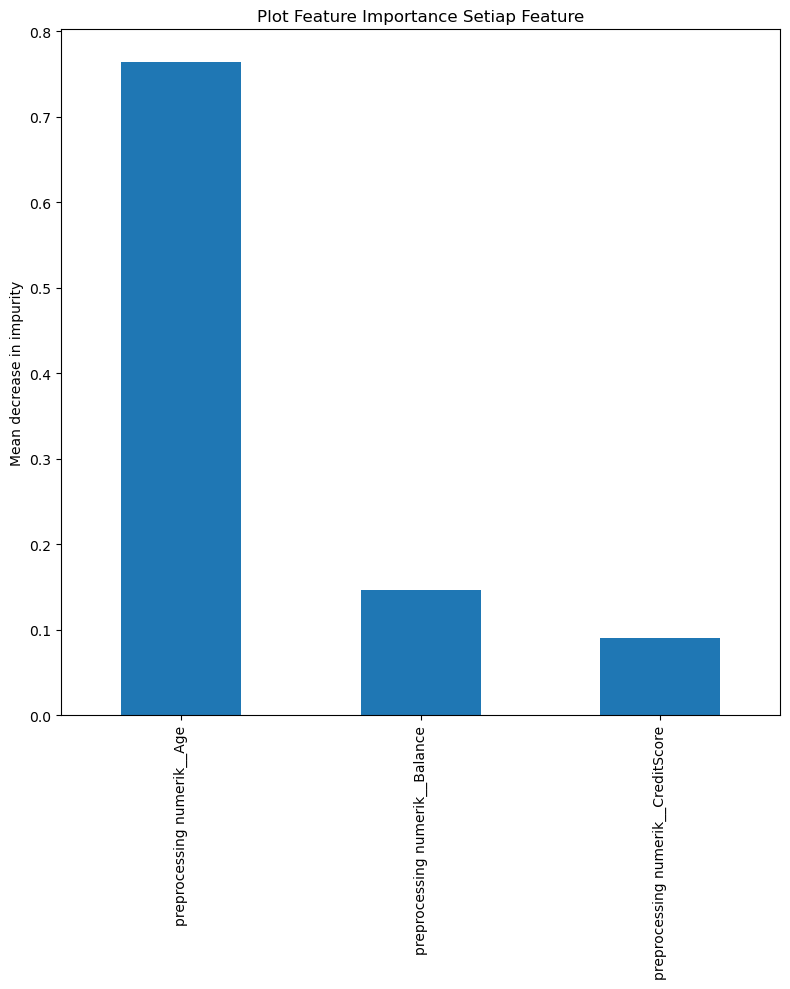

In [95]:
# Melakukan plotting
fig, ax = plt.subplots(figsize = (8,10))
ada_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Plot Feature Importance Setiap Feature")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [111]:
# Mencoba memprediksi training dan test set setelah fitting di training set, kemudian dikemas dalam format DataFrame
pred_train = pd.DataFrame(model_terbaik.predict(X_train), columns=['Exited train'])
pred_test = pd.DataFrame(model_terbaik.predict(X_test), columns=['Exited test'])

In [112]:
# Membandingkan 2 numpy array (kita gunakan np.column_stack untuk menggabungkan kedua array ini)
banding_train = pd.concat([pred_train, y_train], axis=1)
banding_train.rename(columns={banding_train.columns[0]: 'Prediksi', banding_train.columns[1]: 'Asli'}, inplace=True)
banding_train.head()

,Prediksi,Asli
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0


In [113]:
# Membandingkan 2 numpy array (kita gunakan np.column_stack untuk menggabungkan kedua array ini)
banding_test = pd.concat([pred_test, y_test], axis=1)
banding_test.rename(columns={banding_test.columns[0]: 'Prediksi', banding_test.columns[1]: 'Asli'}, inplace=True)
banding_test.head()

,Prediksi,Asli
0,0,0
1,0,1
2,0,0
3,0,0
4,0,0


In [114]:
# Melihat skor akurasi setelah tuning
print(f'Error train set {accuracy_score(y_train, pred_train):.2f}')
print(f'Error test set {accuracy_score(y_test, pred_test):.2f}')

Error train set 0.81
Error test set 0.82


In [115]:
# Melihat skor AUC setelah tuning
print(f'AUC train set = {roc_auc_score(y_train, pred_train):.2f}')
print(f'AUC test set = {roc_auc_score(y_test, pred_test):.2f}')

AUC train set = 0.61
AUC test set = 0.61


In [116]:
# Melihat akurasi dengan menggunakan method 'score'
print(round(model_terbaik.score(X_train, y_train),2))
print(round(model_terbaik.score(X_test, y_test),2))

0.81
0.82


<br>

### Menyimpan Model

In [117]:
# Library untuk menyimpan model
import pickle

In [118]:
# Menyimpan model dengan nama 'model_regresi_terbaik.pkl'
pickle.dump(model_terbaik, open('churn_customer_prediction.pkl', 'wb'))

In [119]:
# Load lagi model yang sudah disimpan dan buka sebagai 'best_model'
best_model = pickle.load(open('churn_customer_prediction.pkl', 'rb'))

In [120]:
# Mencoba melakukan prediksi X_test
prediksi = best_model.predict(X_test)

# Melihat hasil prediksi
prediksi

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [106]:
# Merubah dalam format DataFrame
prediksi = pd.DataFrame(prediksi, columns=['Exited'])
prediksi.head(15)

,Exited
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,0
8,0
9,0
